In [ ]:
# Here is a program for projecting a set of  qubits on a given number 
# of occupied Qubits 
# The PEA method is used with U= e^{2pi i \hat N/ 2^{n0}} 
#--------------------------------------------------------------------
# written by D. Lacroix 
#--------------------------------------------------------------------
# v0 - 31 august 2020 
#--------------------------------------------------------------------
# The program uses the 
# nq   = number of qubits to count
# nr   = number of "working/register" qubits 
# norm = for angle norm = 2^{n0} such that n0 is the minimal value of n such that nq < 2^{n}

In [2]:
#package 
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg' # Makes the images look nice
import numpy as np
import math

# importing Qiskit
from qiskit import IBMQ, Aer
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from matplotlib import pyplot as plt # plot 
from qiskit.providers.ibmq import least_busy # real device
from qiskit.tools.monitor import job_monitor # real device ?

# import basic plot tools
from qiskit.visualization import plot_histogram

In [3]:
# 
# Make the inverse Quantum Fourier Transform for Qubits from 0 to n-1
def qft_dagger(circ, n):
    """n-qubit QFTdagger the first n qubits in circ"""
    # Don't forget the Swaps!
    for qubit in range(n//2):
        circ.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            circ.cu1(-math.pi/float(2**(j-m)), m, j)
        circ.h(j)    

In [4]:
# General variables 
# Example of nq nr norm 
# 2 2 4, 
# 6 
# 9 4 16, 
#18, 3, 32 

# 3 states test
nq = 3   # number of qubits to count 
nr = 2    # number of register/working qubits 
norm = 4   # norm = 2^{nr}  
## 6 states test
#nq = 6   # number of qubits to count 
#nr = 3    # number of register/working qubits 
#norm = 8   # norm = 2^{nr}  

angle = 2*math.pi/norm

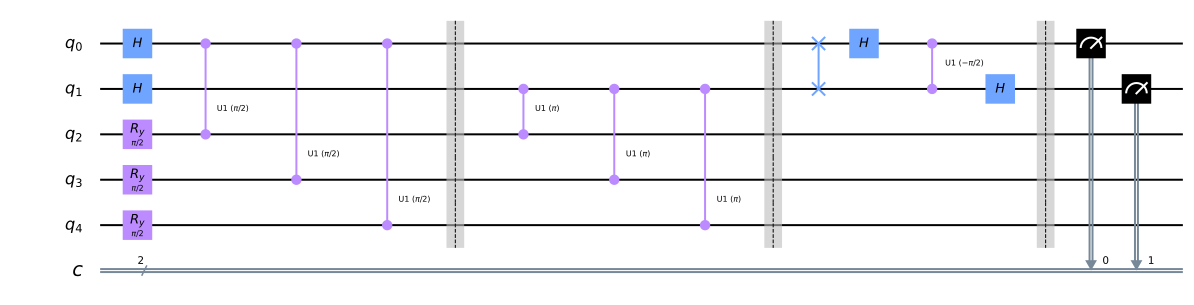

In [5]:
qr = QuantumRegister(nq+nr, 'q')   # qubit of interest + register qubits
cr = ClassicalRegister(nr, 'c') # classical register 
qpe = QuantumCircuit(qr, cr)
# construction of the circuit
# initial state to be counted 
# 

istart=0 # H gate for all
istart=1 # Y rotations for all 

if istart==0:
    qpe.h(qr[nr:nq+nr])

#angle2 = 3*math.pi/4 # angle of the BCS state
#angle2 = 1*math.pi/4 # angle of the BCS state
angle2 = 2*math.pi/4 # angle of the BCS state

if istart==1:
    for i in range(nq): 
        n= i + nr
        qpe.ry(angle2,n)
    
# H gate on register Qubit 
qpe.h(qr[0:nr])

# PEA applied sequentially


for i in range(nr): 
    for j in range(nq):
        qpe.cu1(angle, i, nr+j);
    
    qpe.barrier()
    angle = angle*2
    
# Do the inverse QFT:
qft_dagger(qpe, nr)

# measure 
qpe.barrier()
    
for n in range(nr):
    qpe.measure(n,n)

qpe.draw('mpl')   

{'00': 652, '01': 1861, '10': 1891, '11': 692}


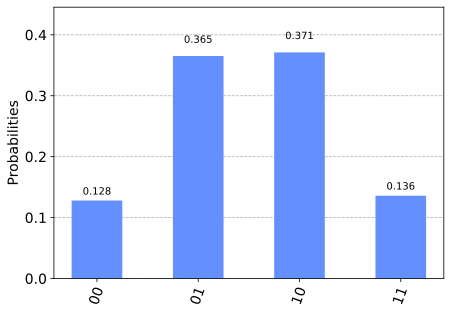

In [6]:
# building our own normalized histo 
# Running the code !
backend = Aer.get_backend('qasm_simulator')
shots = 5096
results = execute(qpe, backend=backend, shots=shots).result()
answer = results.get_counts()

#print(answer['011'])
#answer['011']=10
#print(answer['011'])

print(answer)
plot_histogram(answer)

    

In [7]:
# Load our saved IBMQ accounts and get the least busy backend device with less than or equal to nqubits
nqubits = nr+nq 
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')

iback = 3 # 0: least busy choice, 1:  santiago [5 qubits] , 2: melbourne[15 qubits] 


# least busy choice 
if iback==0:
    backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= nqubits 
                                        and not x.configuration().simulator 
                                        and x.status().operational==True))
# pre-selected backend 
if iback==1:
    backend = provider.get_backend('ibmq_santiago')
    # pre-selected backend 
if iback==2:
    backend = provider.get_backend('ibmq_16_melbourne')
if iback==3:
    backend = provider.get_backend('ibmq_vigo')
    
print("Backend in use: ", backend)

Backend in use:  ibmq_vigo


Job Status: job has successfully run


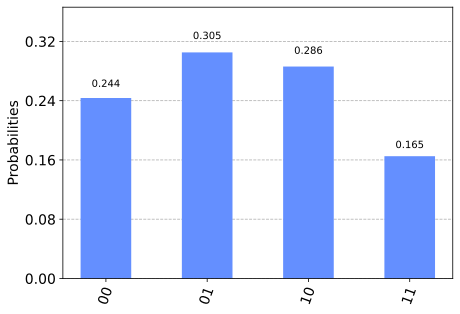

In [8]:
# execute on a real device 
shots = 2048
job = execute(qpe, backend=backend, shots=shots, optimization_level=3)
job_monitor(job)

counts = job.result().get_counts()
plot_histogram(counts)

In [9]:

print(counts)

{'00': 499, '01': 625, '10': 586, '11': 338}
